In [1]:
# Basic Imports
import pathlib
from pathlib import Path
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
from flax.serialization import (
    to_state_dict, msgpack_serialize, from_bytes
)
import optax

# Logging with Tensorboard or Weights and Biases
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

# For ODESolver
from scipy import integrate

# PyTorch for Dataloaders
import torch
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms

# Wandb 
import wandb
import pprint

# Path to import created files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src")

# Import created functions
# from data import make_dataset as mkds
# from visualization import visualize as vis
# from models import train_model as tm
# from models import sampling as smp
import make_dataset as mkds
import visualization as vis
import NN_model as nnm

from numpy.random import default_rng
rng = default_rng(seed=42)

# 0. Create MNIST

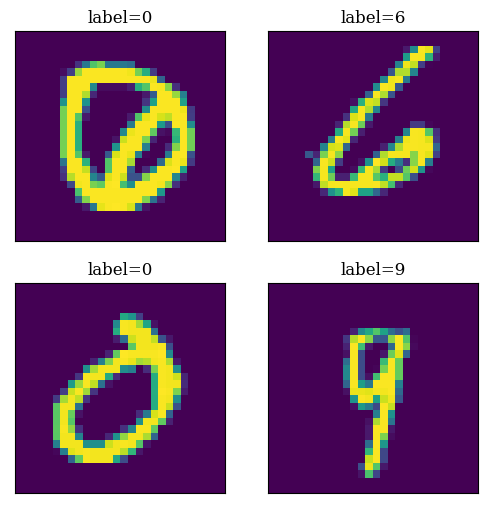

In [2]:
# Instantiate the data loaders
train_dl, val_dl, test_dl = mkds.load_data_loaders(batch_size=128)
# Get a batch of images (batch[0]) and labels (batch[1])
batch = next(iter(train_dl))
# Assign the images to a specific variable that we'll use for training
samples_batch = batch[0]

# # # Visualize samples of the training dataloader
vis.plot_MNIST(train_dl, 4)

# 0.1 Creating Cifar-10

In [3]:
# # Instantiate the data loaders
# cifar_trn_dl, cifar_vdl, cifar_tdl = mkds.load_data_loaders(batch_size=128,
#                                                             dataset=CIFAR10, 
#                                                             data_transform=mkds.cifar_transform)

In [4]:
batch = next(iter(train_dl))

6


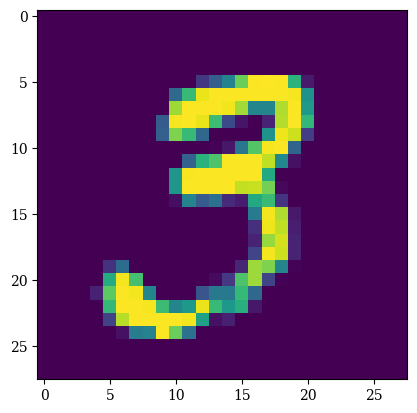

In [5]:
cifar_imgs = batch[0]
cifar_lbls = batch[1]

plt.imshow(cifar_imgs[100])
print(cifar_lbls[0])

# 1. Perturb the samples

In [6]:
def visualize_perturbation_progression(batch, sample_idx, rng, tau=0.01, sigma=0.03, M=291):
    """
    Function to visualize how Algorithm 2 of the paper effects an MNIST sample.

    Args:
    -----
        batch: np.ndarray   
            A batch of images of shape (batchsize, n_channels, img_size, img_size)
        sample_idx: int
            Index of the specific sample to plot.
        rng: np.random.generator_.Generator
            rng used in sampling the hyperparameters in Algorithm 2
        tau: float
            Hyperparameter. Not really clear on what it does :)
        sigma: float
            Noise parameter. Specifically, it's the standard deviation of the
            gaussian distribution that is sampled from to get the noise in for
            the data (y) and the extra dimension (z).
        M: int
            Measure of how far out you go from the distribution.

    Returns:
    -------
        A side by side plot of the input image and it's perturbed version
    """

    tau = [0, 0.3, 1]
    M = [0, 100, 300]
    sigma = [0, 0.03, 1]
    _, y_tilde, _ = mkds.get_perturbed(batch, rng=rng, tau=tau, sigma=sigma, M=M)
    perturbed_img = y_tilde[0]

    fig, ax = plt.subplots(3, 3, figsize=(20,16))
    ax[0,0].imshow(batch[sample_idx])
    ax[0,0].set(title='Unperturbed Sample ($\\tau=0$, $\sigma=0$, $M=0$)')
    ax[0,1].imshow(perturbed_img[sample_idx])
    ax[0,1].set_title(f'Perturbed Sample ($\\tau=${tau}, $\sigma=${sigma}, $M=${M})')
    ax[0,2].imshow(perturbed_img[sample_idx])
    ax[0,2].set_title(f'Perturbed Sample ($\\tau=${tau}, $\sigma=${sigma}, $M=${M})')

    ax[1,0].imshow(batch[sample_idx])
    ax[1,0].set(title='Unperturbed Sample ($\\tau=0$, $\sigma=0$, $M=0$)')
    ax[1,1].imshow(perturbed_img[sample_idx])
    ax[1,1].set_title(f'Perturbed Sample ($\\tau=${tau}, $\sigma=${sigma}, $M=${M})')
    ax[1,2].imshow(perturbed_img[sample_idx])
    ax[1,2].set_title(f'Perturbed Sample ($\\tau=${tau}, $\sigma=${sigma}, $M=${M})')

    ax[2,0].imshow(batch[sample_idx])
    ax[2,0].set(title='Unperturbed Sample ($\\tau=0$, $\sigma=0$, $M=0$)')
    ax[2,1].imshow(perturbed_img[sample_idx])
    ax[2,1].set_title(f'Perturbed Sample ($\\tau=${tau}, $\sigma=${sigma}, $M=${M})')
    ax[2,2].imshow(perturbed_img[sample_idx])
    ax[2,2].set_title(f'Perturbed Sample ($\\tau=${tau}, $\sigma=${sigma}, $M=${M})')
    plt.show()

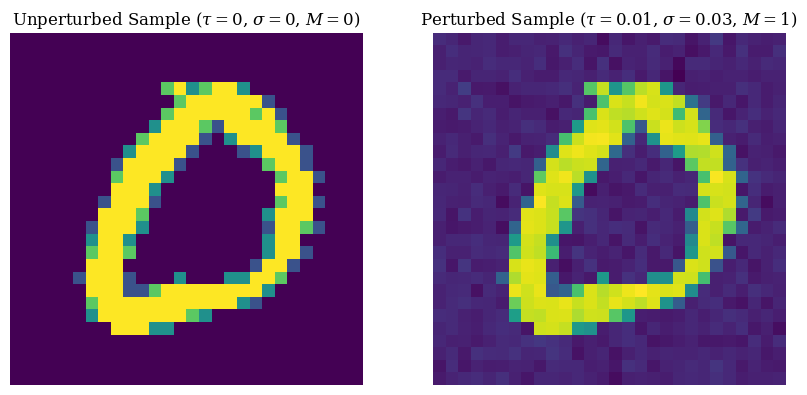

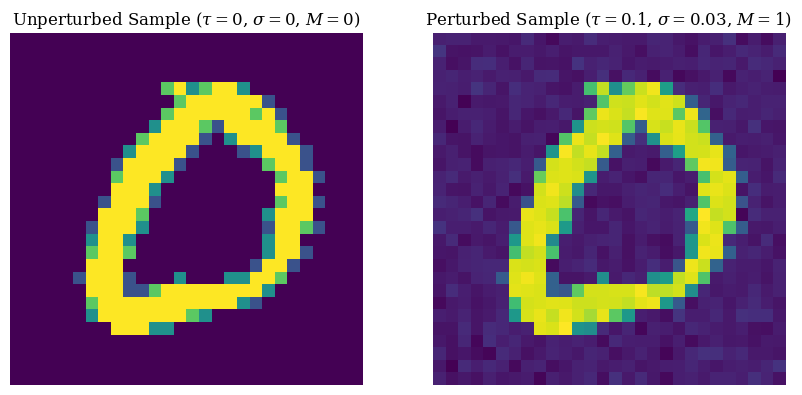

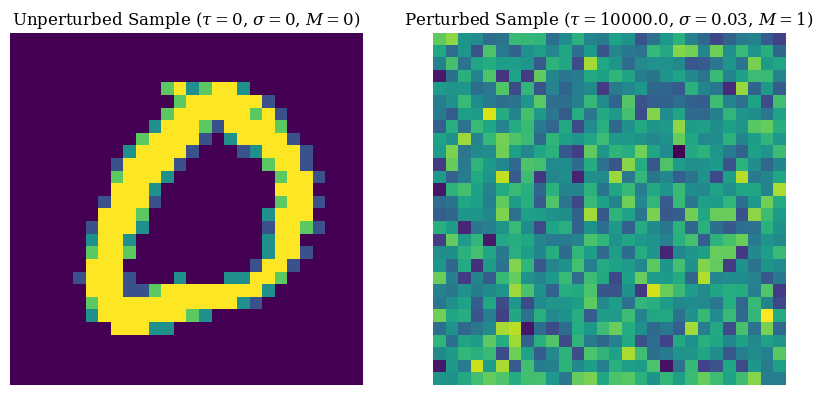

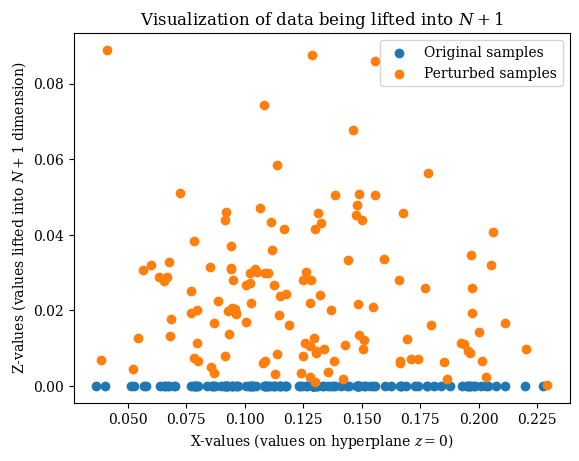

In [7]:
# Create the perturbed data as described in Algorithm 2 of the paper.
# Note: y_tilde = (y, z) and data = np.concatenate(y, z) 
#                        ie. data.shape = (batchsize, imgsize**2 + 1)
x, y_tilde, data = mkds.get_perturbed(samples_batch, rng=rng, M=291)

# # # # Can visualize how the different hyperparameters visually alter an MNIST sample.
vis.visualize_single_perturbed(batch=samples_batch, sample_idx=0, rng=rng, tau=0.01, sigma=.03, M=1)
vis.visualize_single_perturbed(batch=samples_batch, sample_idx=0, rng=rng, tau=0.1, sigma=.03, M=1)
vis.visualize_single_perturbed(batch=samples_batch, sample_idx=0, rng=rng, tau=10000.0, sigma=.03, M=1)

# vis.visualize_single_perturbed(batch=samples_batch, sample_idx=0, rng=rng, tau=0.0, sigma=.1, M=0)

# # # Can visualize how the different hyperparameters change how the MNIST samples are lifted into N+1.
vis.perturb_scatter(samples_batch, rng, M=10)

# 2. Calculate the Poisson/empirical field "labels"

These field coordinates will become the labels we train the NN on.

**Modify `empirical_field` code, so it's clearer how the E fields are being calculated**

(128, 785)
(128, 785)


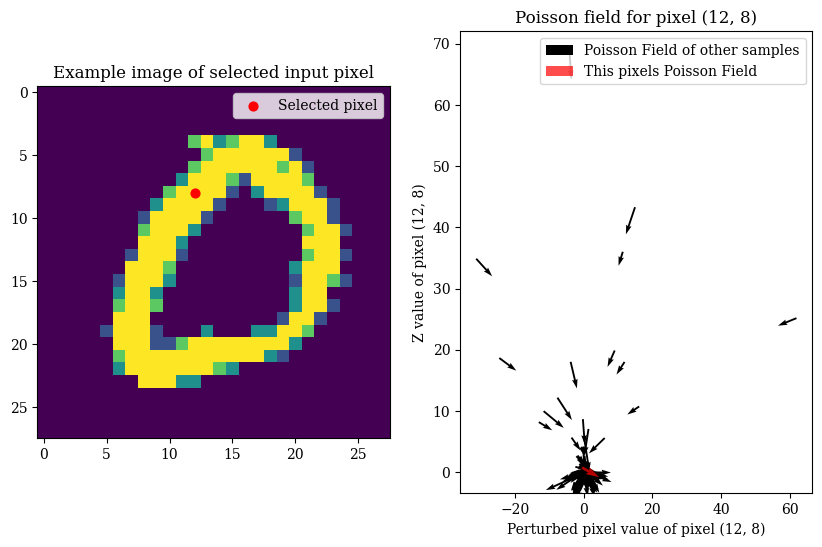

In [8]:
# Create the E field for every batch sample
y, E = mkds.empirical_field(samples_batch, rng)
print(y.shape)
print(E.shape)
# x, y, data = mkds.get_perturbed(samples_batch,rng)

# # Can visualize what the E field in the N+1 dimension would look like
# # for a specific pixel value (red dot in left plot) 
# # for the entire batch of data

vis.visualize_field(batch=samples_batch,
                sample_idx=0, 
                x_coord=12, 
                y_coord=8, 
                rng=rng, 
                set_lims=False)

# 3. Create datasets to be fed into a NN

- Need to figure out a way to create a new dataloader that gives the perturbed vector & empirical field as (imgs, lbls)
- See if there's a way to do it with the base dataloader or if I need to create a "new" perturbed dataset altogether
- Once I have this train the NN and see how to incorporate wandb sweeps into the training.
- Incorporate sampling into the model 
- For the likelihood estimation, see if I can use the base form of the MLP or if I need to change how the model works ie `model(x)` into `model(x,t)` <- which is what they have in the PFGM code.


In [9]:
train_dataset = MNIST('saved_data/train', train=True, transform=mkds.custom_transform, download=True)
train_loader = data.DataLoader(train_dataset,
                               batch_size=32,
                               shuffle=False,
                               drop_last=True,
                               collate_fn=)

In [ ]:
from torch.utils.data import Dataset


class MNIST_perturb(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]      
        image = self.transform(np.array(image))
        return image, label
    def __len__(self):
        return len(self.labels)

In [32]:
# # print(train_dataset[0][1])
# # print(len(train_dataset[5000][0]))
# # plt.imshow(train_dataset[0][0])
# train_dataset[:128, 0]

IndexError: too many indices for tensor of dimension 1

In [16]:
print(train_dataset.shape)
print(train_dataset[0].shape)
print(train_dataset[0][0].shape)

AttributeError: 'MNIST' object has no attribute 'shape'

# 4. Train the NN

In [9]:
CHECKPOINT_PATH = os.getcwd() + '/saved_models'
model_dir = CHECKPOINT_PATH + '/MLP/version_1'
file_path = model_dir + '/metrics' + '/best_eval.json'

In [10]:
img, lbls = next(iter(train_dl))
print(img.shape)
print(lbls.shape)
y, E = mkds.empirical_field(img, rng)
print(y[0:1,:].shape)
print(E.shape)

(128, 28, 28, 1)
(128,)
(1, 785)
(128, 785)


In [11]:
trainer = nnm.MLPTrainer(hidden_dims=[1000, 1000, 1000],
                         output_dim=785,
                         optimizer_hparams={'lr':4e-3,
                                            'optimizer': 'adam'},
                         logger_params={'base_log_dir': CHECKPOINT_PATH},
                         exmp_input=y[0:1, :],
                         check_val_every_n_epoch=1)

metrics = trainer.train_model(train_dl, val_dl, test_dl, num_epochs=2)


                                  MLP Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs         ┃ outputs       ┃ params                   ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ - float32[785] │ float32[785]  │                          │
│         │        │ - train: True  │               │                          │
├─────────┼────────┼────────────────┼───────────────┼──────────────────────────┤
│ Dense_0 │ Dense  │ float32[785]   │ float32[1000] │ bias: float32[1000]      │
│         │        │                │               │ kernel:                  │
│         │        │                │               │ float32[785,1000]        │
│         │        │                │               │                          │
│         │        │                │               │ 786,000 (3.1 MB)         │
├─────────┼────────┼───────

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/390 [00:00<?, ?it/s]

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float32[128,784])>with<DynamicJaxprTrace(level=0/1)>
The error occurred while tracing the function train_step at /Users/matt/Desktop/UCI_Research/LSST/PFGM/PFGM_MNIST/NN_model.py:51 for jit. This concrete value was not available in Python because it depends on the value of the argument 'batch'.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

# 5. Using Wandb sweep 

In [1]:
wandb.login()

sweep_config = {
    "method": "grid"
}

metric = {
    "name": "train_loss",
    "goal": "minimize",
    "name": "val_loss",
    "goal": "minimize"
}

sweep_config["metric"] = metric

parameters_dict = {
    "optimizer": {
        "values": ["adam", "adamw", "sgd"]
    },
    "num_layers": {
        "values": [10]
    },
    "num_features": {
        "values": [256, 512, 1024]
    },
    "epochs": {
        "values": [2, 4, 8]
    },
    "learning_rate": {
        "values": [1e-4]
    },
    "batch_size": {
        "values": [64, 128]
    },
}

sweep_config["parameters"] = parameters_dict

NameError: name 'wandb' is not defined

In [ ]:
pprint.pprint(sweep_config)

In [ ]:
# def sample_unit_sphere(N_dim, samples, rng):
#     x = rng.standard_normal(size=(samples, N_dim))
#     x /= np.linalg.norm(x, ord=2, axis=-1, keepdims=True)
#     return x

# rng = default_rng()
# u = sample_unit_sphere(2, 100, rng)
# plt.plot(*u.T, '.')